<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**MODELOS DE PROGRAMACION: MODELO ADIABATICO** -
Prof: Carmen Pellicer Lostao

# Understanding Minor-Embedding

In this notebook we will deep into the concepts of embedding, to understand how the QPU is programmed at low level.

For an introduction to minor-embedding, see [Minor-Embedding](https://docs.ocean.dwavesys.com/en/stable/concepts/embedding.html).

For an introduction to the topologies of D-Wave hardware graphs, see [QPU Topology](https://docs.ocean.dwavesys.com/en/stable/concepts/topology.html). Leap users also have access to the Exploring Pegasus Jupyter Notebook that explains the architecture of D-Wave’s quantum computer, Advantage, in further detail.

Two types of embedding:

- Minor-embedding can be done manually, though typically for very small problems only. 

- Minor-embedding can also be automated through Ocean. `minorminer` library is used by several [Ocean embedding composite](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html) for this purpose. 

Once an embedding has been found, D-Wave’s Problem Inspector tool can be used to evaluate its quality. See [Using the Problem Inspector](https://docs.ocean.dwavesys.com/en/stable/examples/inspector_graph_partitioning.html) for more information

## Libraries and installs

If necessary we install ocean libs and can set-up the environment

In [ ]:
!pip install dwave-ocean-sdk

In [ ]:
!dwave setup

In [ ]:
!dwave config inspect

Lista los solvers

In [ ]:
!dwave solvers --list --all

## General embeding

General embedding refers to embedding that may be useful for any type of graph. I takes one graph and maps it into another

[`minorminer`](https://pypi.org/project/minorminer/) is a python library of tools for finding graph minor embeddings, developed to embed Ising problems onto quantum annealers (QA).

While this library can be used to find minors in arbitrary graphs, it is particularly geared towards state-of-the-art QA: problem graphs of a few to a few hundred variables, and hardware graphs of a few thousand qubits.

`minorminer` has both a Python and C++ API, and includes implementations of multiple embedding algorithms to best fit different problems.

### Find embeddings

The primary utility function, [`find_embedding()`](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/reference/general_embedding.html), is an implementation of this [heuristic algorithm](https://arxiv.org/abs/1406.2741). It accepts various optional parameters used to tune the algorithm’s execution or constrain the given problem.

The function takes two NetworkX graphs $S$ and $T$ and returns a python dictionary that maps labels in $S$ to lists of labels in $T$. If the heuristic fails to find an embedding, an empty dictionary is returned.

Embedding is heuristic, then you need a certain random seed to make the result repeatable.


In [ ]:
from minorminer import find_embedding

#Embedding a K3 source graph into a square target graph by chaining two target nodes to represent one source node

# A triangle is a minor of a square.
triangle = [(0, 1), (1, 2), (2, 0)]
square = [(0, 1), (1, 2), (2, 3), (3, 0)]

# Find an assignment of sets of square variables to the triangle variables
embedding = find_embedding(triangle, square, random_seed=61)
print(len(embedding))  # 3, one key in the dict for each variable in the triangle
print(embedding)

# We don't know which variables will be assigned where, here are a possible outputs:
# for random_seed=61
# variable 0 -> qubits [0, 1], variable 1 -> qubits [2], , variable 2 -> qubits [3]
# {0: [0, 1], 1: [2], 2: [3]}

![image](https://docs.ocean.dwavesys.com/en/stable/_images/Embedding_TriangularSquare.png)

Other examples of use of this function

In [ ]:
# This minorminer execution of the example requires that source variable 0
# always be assigned to target node 2
embedding = find_embedding(triangle, square, fixed_chains={0: [2]})
print(embedding)


In [ ]:
# This minorminer execution of the example suggests that source variable 0
#be assigned to target node 2 as a starting point for finding an embedding.
embedding = find_embedding(triangle, square, initial_chains={0: [2]})
print(embedding)
# [[2], [0, 3], [1]]
# [[0], [3], [1, 2]]
# Output where source variable 0 has switched to a different target node is possible.

### Embedding in QPU topology graphs

[dwave-networkx](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) library has tools to create graphs of QPU topologies and draw the embeddings we perform on them


We have the functions to build graphs:
*   [`chimera_graph()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.chimera_graph.html)
*   [`pegasus_graph()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.pegasus_graph.html)
*   [`zephyr_graph()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.zephyr_graph.html)

and to draw graphs and embeddings:
*   [`draw_chimera_embedding()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.drawing.chimera_layout.draw_chimera_embedding.html#dwave_networkx.drawing.chimera_layout.draw_chimera_embedding)
*   [`draw_pegasus_embedding()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.drawing.pegasus_layout.draw_pegasus_embedding.html)
*   [`draw_zephyr_embedding()`](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.drawing.zephyr_layout.draw_zephyr_embedding.html)



To ilustrate an example of use of these functions we will embed clique graphs on these topologies and use [`find_clique_embedding() `](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/reference/clique_embedding.html) that may produce better embeddings than the generic `find_embedding()` method if the source graph is a clique.

In [ ]:
# This example minor embeds a fully connected K5 graph into a chimera graph

import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt
from minorminer import busclique

C = dnx.chimera_graph(2, 2)
embedding = busclique.find_clique_embedding(5, C)

print('embedding',embedding)
print('number of qubits requiered', sum([len(k) for k in embedding.values()]))
# There are many possible outputs, and sometimes it might fail and return an empty list

In [ ]:
# we can draw the embedding passing the QPU topology graph (C = dnx.chimera_graph(2, 2)) and the embedding
dnx.draw_chimera_embedding(C,embedding, show_labels=True)

### EXERCICE

Try embedding the $K_5$ in Pegasus or Zephys graphs.

Consider generating Clique graphs of higher order and check the embeddings in both topologies.

embedding {0: (12, 28), 1: (13, 29), 2: (10, 30), 3: (11, 31), 4: (14, 32)}
number of qubits requiered 10


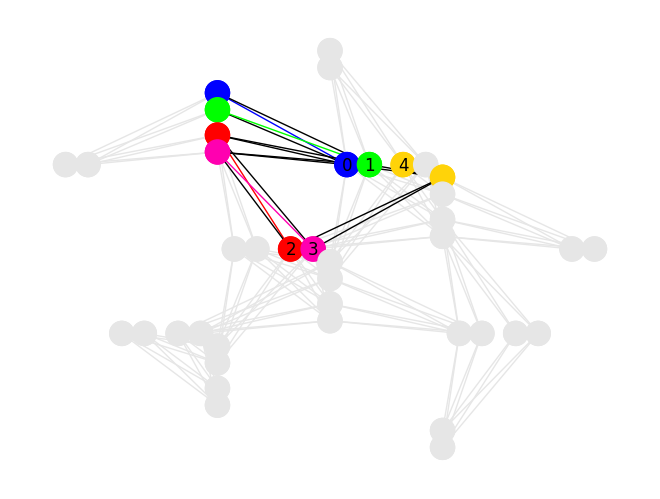

In [3]:
# Pegasus

import networkx as nx
import dwave_networkx as dnx
from minorminer import busclique

pgraph=dnx.pegasus_graph(2)
embedding = busclique.find_clique_embedding(5, pgraph)

print('embedding',embedding)
print('number of qubits requiered', sum([len(k) for k in embedding.values()]))
# There are many possible outputs, and sometimes it might fail and return an empty list

dnx.draw_pegasus_embedding(pgraph,embedding, show_labels=True)

embedding {0: (8, 32), 1: (9, 33), 2: (10, 34), 3: (11, 35), 4: (12, 36)}
number of qubits requiered 10


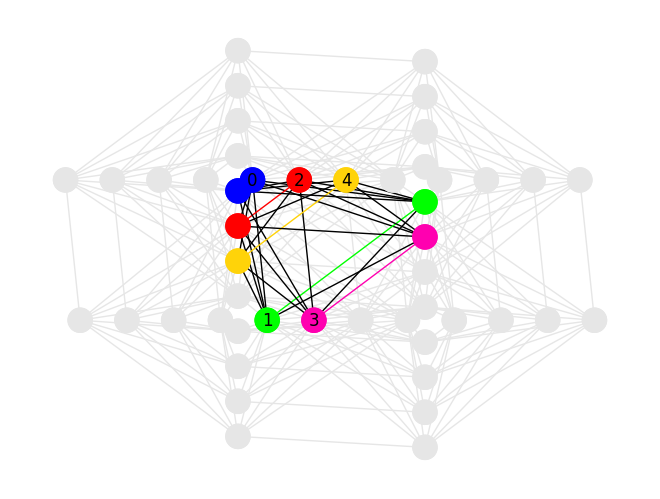

In [6]:
# Zephyr

import networkx as nx
import dwave_networkx as dnx
from minorminer import busclique

zgraph=dnx.zephyr_graph(1)
embedding = busclique.find_clique_embedding(5, zgraph)

print('embedding',embedding)
print('number of qubits requiered', sum([len(k) for k in embedding.values()]))
# There are many possible outputs, and sometimes it might fail and return an empty list

dnx.draw_zephyr_embedding(zgraph,embedding, show_labels=True)

## Embedding SAT problems: Boolean NOT and AND Gates

Here we experiment how embedding works for two very simple SAT problems  (the Boolean NOT and AND gates) on a D-Wave system to demonstrate programming the underlying hardware more directly; in particular, minor-embedding a chain.

[Minor-embedding](https://docs.dwavesys.com/docs/latest/c_gs_7.html) is an advanced step that can be considered to control QPU in a low level.

Let's start formulating logic circuit gate problems as QUBOs and Embedding them in QPU

### NOT gate

As we saw when we were dealing with SAT problems you can represent a NOT gate ($x_1$ the input and $x_2$ the output) $x_2=¬x_1$ as the following QM

$$ E(x)= 2x_1x_2-x_1-x_2+1$$

This is a simple QUBO that we build algebraically from the equality (substracting the terms of the equality and square it $(x_1+x_2-1)^2$) and the fact that for binary valued variables, you can substitute  $¬x_1 =(1−x_1)$.



In [ ]:
Q_not = {('x1', 'x2'): -1, ('x1', 'x2'): 2, ('x2', 'x1'): 0, ('x2', 'x2'): -1}

### Solve the Problem by Sampling (Automated Minor-Embedding)

Again we use sampler [`DWaveSampler()`](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#dwavesampler) from Ocean software’s dwave-system and its [`EmbeddingComposite()`](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#embedding)composite to minor-embed the unstructured problem (variables $x_1,x_2$, and $x_3$) on the sampler’s graph structure (the QPU’s numerically indexed qubits).

The next code sets up a D-Wave system as the sampler.

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = DWaveSampler()
sampler_embedded = EmbeddingComposite(sampler)

sampleset = sampler_embedded.sample_qubo(Q_not, num_reads=5000, label='SDK Examples - AND Gate')
print(sampleset)

Almost all the returned samples from this execution represent valid value assignments for a NOT gate, and minimize (are low-energy states of) the BQM.

Let's see the embedding in the [Problem Inspector](). The figure below shows this embedding of the NOT gate onto an Advantage QPU.

In [ ]:
import dwave.inspector

# Inspect the problems sampleset
dwave.inspector.show(sampleset)

Notice that coupling strength is BIAS 0.5 above: the QPU can be viewed as minimizing the Ising model, with linear biases setting the amplitudes of magnetic fields applied to qubits and quadratic biases the strength of coupling between qubits.

While QUBOs are more convenient to work with for some problems, Ocean converts problems submitted to a QPU to equivalent Ising models, producing the $J_{1,2}$ bias of 0.5 for the qubits connection coupler shown above (and , not shown, zero $h_1=h_2$ biases on the two qubits):

In [ ]:
import dimod
dimod.qubo_to_ising(Q_not)

### Minor embedding NOT gate QUBO problem

Minor embedding maps the two problem variables $x_1$ and $x_2$ to the indexed qubits of the D-Wave QPU. Here, you will do this mapping yourself.

The next line of code looks at the `nodelist` property of the s`ampler`. Select the first node, which on a QPU is a qubit, and print its adjacent nodes, which are the qubits it is coupled to.

In [ ]:
print('first qbit used in the sampler',sampler.nodelist[0])

print('qbits connected to the first in the sampler',sampler.adjacency[sampler.nodelist[0]])

For the Advantage system the above code ran on in this particular execution, you see that the first available qubit, 30, is adjacent to qubit 31 and a few others. These nodes are in the edge of the graph and have limited connection.

You can map the NOT problem’s two linear coefficients (coefficients of the $-x_1$
 and $-x_2$ terms) and single quadratic coefficient (coefficient of the $2x_1x_2$ term) to $q_1=q_2=-1$ biases applied to the Advantage’s qubits 30 and 31 and a $q_{1,2}=2$ coupling strength applied to coupler [30, 31].

The following code uses the [FixedEmbeddingComposite](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#dwave.system.composites.FixedEmbeddingComposite) composite to manually minor-embed the problem on this Advantage QPU.

Note: For your selected QPU, use your `sampler.nodelist[0]` qubit for $x_1$
 and any of its adjacent qubits, sampler.adjacency `[sampler.nodelist[0]]`, for
, as done above.

In [ ]:
from dwave.system import FixedEmbeddingComposite
sampler_embedded = FixedEmbeddingComposite(sampler, {"x1": [30], "x2": [31]})
print(sampler_embedded.adjacency["x1"])

In [ ]:
sampleset = sampler_embedded.sample_qubo(Q_not, num_reads=5000, label='SDK Examples - AND Gate')
print(sampleset)

As before, most the results from 5000 samples are valid states of a NOT gate, with complementary values for $x_1$
 and $x_2$.

 Let's see the embedding in the problem inspector

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)

The crucial point to understand in this subsection is that you cannot map the set of your problem’s variables to a set of arbitrary qubits. Quadratic models have interactions between some pairs of the variables and those require the existence of couplers between the qubits representing such variable pairs; because the graph of a QPU is not fully connected, not all qubits are coupled. For interacting variables $x_1,x_2$
 of the NOT gate, the selection of qubit 30 for variable $x_1$
 severely limits the possible choices of qubits that can represent variable $x_2$

### AND gate

As we saw in the notebook to solve SAT problems DWave `dimod` library has interesting tools to generate QUBO functions for different SAT conditions

In [ ]:
from dimod.generators import or_gate, and_gate, combinations
# generating BQM models

#generate a BQM  with variables x1, x2, x3, x4 that exactly 2 of the four variables are 1 satisfy the condition of min energy
bqm_4_2 = combinations(['x1', 'x2', 'x3', 'x4'], 2)

#generate a BQM for 3 variables that satisfy the OR operation x1vx2=x3
bqm_or = or_gate('x1', 'x2', 'x3')

#generate a BQM for 3 variables that satisfy the AND operation x1^x2=x3
bqm_and = and_gate('x1', 'x2', 'x3')


We will work with the Boolean AND Gate QM

In [ ]:
bqm_and

Mathematically this QM corresponds to:
$$ E(x)= 3x_3 + x_1x_2 + -2x_1x_3 -2x_2x_3$$

And as a matrix:

$$Q= \begin{bmatrix} 0 & 1 & -2 \\ 0 & 0 & -2 \\ 0 & 0 & -3 \end{bmatrix} $$

where $x_1, x_2$ are the inputs and $x_3$ is the output of the AND gate

### Solve the Problem by Sampling (Automated Minor-Embedding)

Again we use sampler [`DWaveSampler()`](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#dwavesampler) from Ocean software’s dwave-system and its [`EmbeddingComposite()`](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#embedding) composite to minor-embed the unstructured problem (variables $x_1,x_2$, and $x_3$) on the sampler’s graph structure (the QPU’s numerically indexed qubits).

The next code sets up a D-Wave system as the sampler.

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = DWaveSampler()
sampler_embedded = EmbeddingComposite(sampler)

sampleset = sampler_embedded.sample(bqm_and, num_reads=5000,
                                         label='SDK Examples - AND Gate')
print(sampleset)

All the returned samples from this execution represent valid value assignments for an AND gate, and minimize (are low-energy states of) the BQM.

### Minor Embedding NOT, AND gates and Larger Problems

The BQM for a NOT gate, $ -x_1-x_2+2x_1x_2$, can be represented by a fully connected $K_2$ graph: its linear coefficients are weights of the two connected nodes with the single quadratic coefficient the weight of its connecting edge.

The BQM for an AND gate, $ 3x_3 + x_1x_2 + -2x_1x_3 -2x_2x_3$, needs a $K_3$ graph.

<div>
<img src="https://docs.ocean.dwavesys.com/en/stable/_images/Embedding_NOTvsAND.png" width="300">
</div>

Previously, to minor-embed a $K_2$  graph on a QPU, you selected an arbitrary qubit (for simplicity, the first listed) and could then select as the second any of the qubits coupled to the first. Minor-embedding a $K_3$ graph on a D-Wave QPU is less straightforward.

Consider trying to expand the minor embedding you found for the NOT gate above to the AND gate. On the same QPU, map $x_1$ and $x_2$ to the qubits used before, 30 and 31, respectively. For $x_3$ you now need a third qubit coupled to both:

In [ ]:
#In the sampler Pegasus Topology
set1=sampler.adjacency[30]
set2=sampler.adjacency[31]
print(set1)
print(set2)

#use python set intersection to check if there are common coupled qbits
print('common qbits', set1.intersection(set2)) #none in common

Qubit 30 is coupled to 5 additional qubits and qubit 31 is coupled to 6 but none common to both.

In the Pegasus topology, most qubits couple to 15 other qubits. The qubits used here couple to fewer because of their positions at the edge of the QPU graph.

Because each qubit is coupled to a limited set of other qubits, only a minority of coupled qubits are also coupled in common to a third qubit.

In this case, a more successful selection for variables $x_1$ and $x_2$
 is the set of qubits 30 and 2985. Both these qubits are also coupled to qubit 45 and 2970.

In [ ]:
#In the sampler Pegasus Topology
set1=sampler.adjacency[30]
set2=sampler.adjacency[2985]
print(set1)
print(set2)

#use python set intersection to check if there are common coupled qbits
print('common qbits', set1.intersection(set2)) #none in common

The figure below shows a minor embedding of the AND gate onto an Advantage QPU

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)

Can you always make a successful selection of qubits such that all your problem’s variables are mapped to qubits with couplings that can represent all the problem’s interactions?

Such one-to-one embeddings, with each graph node represented by a single qubit, are called **native embeddings**.

The largest clique you can embed natively on the Pegasus topology is a $K_4$. Larger cliques such as $K_5$, as well as large, non-clique (“sparse”) graphs, require **chaining qubits**.

### Chains

To understand how chaining qubits overcomes the problem of sparse connectivity, consider minor embedding the triangular $K_3$ graph below into two target graphs, one sparser than the other. The graphic below shows two such embeddings: the $K_3$ graph is mapped on the left to a fully-connected graph of four nodes (a $K_4$ complete graph ) and on the right to a sparser graph, also of four nodes.

<div>
<img src="https://docs.ocean.dwavesys.com/en/stable/_images/chain_triangle_four_qubits.png" width="500">
</div>

For the left-hand embedding, you can choose any mapping between $a,b,c$
 and $0,1,2,3$; here $a,b,c$ are mapped to $2,0,1$, respectively. For the right-hand embedding, however, no choice of just three target nodes suffices. The same $2,0,1$ target nodes leaves $b$ disconnected from $c$. Chaining target nodes $0$ and $3$ to represent node $b$ makes use of both the connection between $0$ to $2$ and the connection between $3$ and $1$
.

On QPUs, **chaining qubits** is accomplished by setting the strength of their connecting couplers negative enough to **strongly correlate the states of the chained qubits;** if at the end of most anneals these qubits are in the same classical state, representing the same binary value in the objective function, they are in effect acting as a single variable.

The strength of the coupler between qubits 0 and 3, which represents $b$ variable, must be set to correlate the qubits strongly, so that in most solutions they have a single value for $x_3$. The **chain_b**. column in solver results stands for “**chain breaks**”, which is when **qubits in a chain take different values**.)

The previous subsection showed that if you mapped the AND problem’s variables
$x_1$ and $x_2$ to qubits 30 and 31, respectively, on the QPU used before, you could not find a single qubit coupled to both for variable $x_3$. But notice, for example, that qubit 30 (representing $x_1$) is coupled to qubit 45 and qubit 31 (representing $x_2$) is coupled to qubit 46. You can represent variable $x_3$ as a chain of qubits 45 and 46, which are coupled:

In [ ]:
print('is true that (45, 46) are connected?', (45, 46) in sampler.edgelist )

sampler_embedded = FixedEmbeddingComposite(sampler, {"x1": [30], "x2": [31], "x3": [45, 46]})
sampleset = sampler_embedded.sample(bqm_and, num_reads=5000,
                                         label='SDK Examples - AND Gate')
print(sampleset)

The problem inspector shows this minor embedding of the AND gate onto this Advantage QPU.

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)

### Chain strength

For illustrative purposes, this subsection purposely weakens the chain strength (strength of the coupling between qubits 45 and 46, which represent variable $x_3$).

Previously we saw that the chain strength by default was set close to 1.

In [ ]:
print(round(sampleset.info['embedding_context']['chain_strength'], 3))

The following code explicitly sets chain strength to a lower value of 0.25. Consequently, the two qubits are less strongly correlated and the result is that many returned samples represent invalid states for an AND gate.

In [ ]:
import dwave.inspector
sampleset = sampler_embedded.sample(bqm_and, num_reads=5000,
                                         chain_strength=0.25,
                                         label='SDK Examples - AND Gate')
print(sampleset)

In this case, as above, you are likely to see many samples with broken chains (these have non-zero values in the chain_b. column) and calling the problem inspector shows these:

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)

## Solving problems with different Minor-Embedding and QPU Topologies

In practice, we can use embedding on different topologies selecting the topology type of the solver.

We can embed a QUBO into a topology specifying the `topology_type` parameter of the solver.

In [ ]:
import dwavebinarycsp
import dwave.inspector
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [ ]:
## ADVANCED
sampler = EmbeddingComposite(DWaveSampler()) #pegasus - chimera don't exists
adv_sampler = EmbeddingComposite(DWaveSampler(solver=dict(topology__type='pegasus')))
adv2p_sampler = EmbeddingComposite(DWaveSampler(solver=dict(topology__type="zephyr")))

In [ ]:
sampleset = adv_sampler.sample(bqm_and, num_reads=5000, label='SDK Examples - AND Gate')
print(sampleset)

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)

In [ ]:
## ADVANCED2
sampleset = adv2p_sampler.sample(bqm_and, num_reads=5000, label='SDK Examples - AND Gate')
print(sampleset)

In [ ]:
# Inspect the problems sampleset
dwave.inspector.show(sampleset)